# 2. How to create a Measurement
In this demo, I'll show how to create a **Measurement**.

To create a Measurement, you first need to create a **Database** where the data is stored.

An **Experiment** is a collection of **DataSet**s, each associated with a different Measurement, that you can look up in the Database.

In [1]:
import qcodes as qc
import numpy as np

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/guen/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/guen/.qcodes/logs/211019-25969-qcodes.log


## Initialize database

To run a measurement and save a dataset, you'll need a database.

By default, a SQlite database is created in your home directory `~/experiments.db`, but here we will add it to the current folder.

In [3]:
qc.initialise_or_create_database_at("./experiments.db")

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████| 1/1 [00:00<00:00, 310.76it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████| 1/1 [00:00<00:00, 262.11it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████████| 1/1 [00:00<00:00, 273.96it/s]


## Create experiment

Now, you can create an experiment. This represents a set of Measurements and associated DataSets that have a single sample name in common.

In [4]:
exp = qc.load_or_create_experiment(experiment_name='My First Experiment',
                                   sample_name="My Sample")

## Load Station

As described in the previous demo, now load the Station from the configuration file.

In [5]:
station = qc.Station()
station.load_config_file("station.yml")
dac = station.load_dac(gates=["ch1", "ch2"])
dmm = station.load_dmm(setter_instr=dac)

## Create and run a Measurement

Let's create and run a simple measurement.

In [6]:
# Create a measurement that is associated with your experiment and station
meas = qc.Measurement(exp=exp, station=station, name='My First Measurement')
# register an independent parameter
meas.register_parameter(dac.ch1)
# now register a dependent variable that uses the independent parameter as a setpoint
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))
# Set the write period, this specifies how often the data is written to disk
meas.write_period = 2

# Start measurement
with meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 1. 


([<AxesSubplot:title={'center':'Run #1, Experiment My First Experiment (My Sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

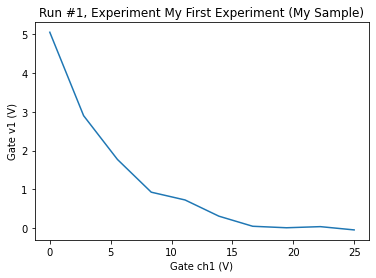

In [7]:
from qcodes.dataset.plotting import plot_dataset
plot_dataset(dataset)

In [8]:
dataset

My First Measurement #1@/Users/guen/repos/guen/qcodes_demo/experiments.db
-------------------------------------------------------------------------
dac_ch1 - numeric
dmm_v1 - numeric

In [9]:
dataset.run_id

1

In [10]:
exp

My First Experiment#My Sample#1@/Users/guen/repos/guen/qcodes_demo/experiments.db
---------------------------------------------------------------------------------
1-My First Measurement-1-dac_ch1,dmm_v1-10

In [11]:
exp.data_set(1)

My First Measurement #1@/Users/guen/repos/guen/qcodes_demo/experiments.db
-------------------------------------------------------------------------
dac_ch1 - numeric
dmm_v1 - numeric

In [12]:
dataset.to_pandas_dataframe()

,dmm_v1
dac_ch1,
0.000000,5.056538
2.777778,2.900492
5.555556,1.769761
8.333333,0.923373
11.111111,0.722125
13.888889,0.303392
16.666667,0.042592
19.444444,0.003936
22.222222,0.032926


## 2D Measurement

You can add any number of parameters to your measurement! The code below adds a second independent parameter, and plots it to a heatmap.

In [13]:
meas = qc.Measurement(exp=exp, station=station, name='My First 2D Measurement')
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))

meas.write_period = 2

with meas.run() as datasaver:
    for set_v1 in np.linspace(0, 25, 10):
        for set_v2 in np.linspace(0, 25, 10):
            dac.ch1.set(set_v)
            get_v = dmm.v1.get()
            datasaver.add_result((dac.ch1, set_v1),
                                 (dac.ch2, set_v2),
                                 (dmm.v1, get_v))

    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 2. 


([<AxesSubplot:title={'center':'Run #2, Experiment My First Experiment (My Sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x7fb3770be2d0>])

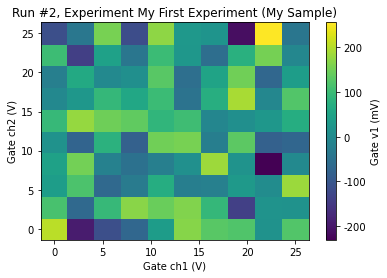

In [14]:
plot_dataset(dataset)

In [15]:
from qcodes.interactive_widget import experiments_widget
experiments_widget()